### MCMC pour déterminer les paramètres du modèle hydraulique

| Paramètre                        | Loi de probabilité mentionnée                                      |
|----------------------------------|------------------------------------------------------------------|
| Débit Q                   | Loi triangulaire (Q_min, Q_mode, Q_max)     |
| Coefficient de Strickler K_s | Loi triangulaire (K_s,min, K_s,mode, K_s,max) |
| Hauteur de la digue h_d    | Constante (pas mentionnée comme incertaine)                     |
| Cote du fond en amont Z_m et en aval Z_v | Constante (non explicitement mentionnée comme incertaine) |

### 📂 Importation des données & librairies

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
L = 5000 
B = 300   
hd = 5.50 # Hauteur de la digue (m) isu de l'analyse des crues
Zb = 55.5 
N = 5000

Q_samples = np.zeros(N)
Ks_samples = np.zeros(N)
Zv_samples = np.zeros(N)
Zm_samples = np.zeros(N)
H_samples = np.zeros(N)
S_samples = np.zeros(N)

# Conditions initiales posées arbitrairement
Q_samples[0] = 1013  
Ks_samples[0] = 30   
Zv_samples[0] = 50   
Zm_samples[0] = 55 

Définitions de mes lois 

In [21]:
def gumbel_pdf(x, mode=1013, beta=558):
    return (1/beta) * np.exp(-(x - mode) / beta) * np.exp(-np.exp(-(x - mode) / beta))

def normal_pdf(x, mu=30, sigma=7.5):
    return (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)

def triangular_pdf(x, lower, upper, mode):
    if lower <= x <= mode:
        return 2 * (x - lower) / ((upper - lower) * (mode - lower))
    elif mode < x <= upper:
        return 2 * (upper - x) / ((upper - lower) * (upper - mode))
    else:
        return 0

In [ ]:
for i in range(1, N):

    #éviter les valeurs négatives
    Q_prop = max(0.1, np.random.normal(Q_samples[i-1], 50))  
    Ks_prop = max(0.1, np.random.normal(Ks_samples[i-1], 2))
    Zv_prop = np.random.normal(Zv_samples[i-1], 0.5)
    Zm_prop = max(Zv_prop + 0.1, np.random.normal(Zm_samples[i-1], 0.5))  # Assure Zm > Zv

    alpha_Q = min(1, gumbel_pdf(Q_prop) / gumbel_pdf(Q_samples[i-1]))
    alpha_Ks = min(1, normal_pdf(Ks_prop) / normal_pdf(Ks_samples[i-1]))
    alpha_Zv = min(1, triangular_pdf(Zv_prop, 49, 51, 50) / triangular_pdf(Zv_samples[i-1], 49, 51, 50))
    alpha_Zm = min(1, triangular_pdf(Zm_prop, 54, 56, 55) / triangular_pdf(Zm_samples[i-1], 54, 56, 55))

    Q_samples[i] = Q_prop if np.random.rand() < alpha_Q else Q_samples[i-1]
    Ks_samples[i] = Ks_prop if np.random.rand() < alpha_Ks else Ks_samples[i-1]
    Zv_samples[i] = Zv_prop if np.random.rand() < alpha_Zv else Zv_samples[i-1]
    Zm_samples[i] = Zm_prop if np.random.rand() < alpha_Zm else Zm_samples[i-1]

    #H
    delta_Z = max(0.001, Zm_samples[i] - Zv_samples[i])  # Empêche une valeur négative
    H_samples[i] = (Q_samples[i] / (Ks_samples[i] * np.sqrt(delta_Z / L) * B)) ** (3/5)

    #S
    S_samples[i] = Zv_samples[i] + H_samples[i] - hd - Zb

Statistiques descriptives

In [23]:
H_mean, H_std = np.mean(H_samples), np.std(H_samples)
S_mean, S_std = np.mean(S_samples), np.std(S_samples)
H_lower, H_upper = np.percentile(H_samples, [2.5, 97.5])
S_lower, S_upper = np.percentile(S_samples, [2.5, 97.5])

H_summary = {
    "Hauteur d'eau moyenne (H)": H_mean,
    "Écart-type (H)": H_std,
    "IC 95% inf. (H)": H_lower,
    "IC 95% sup. (H)": H_upper
}

S_summary = {
    "Surverse moyenne (S)": S_mean,
    "Écart-type (S)": S_std,
    "IC 95% inf. (S)": S_lower,
    "IC 95% sup. (S)": S_upper
}

df_summary = pd.DataFrame([H_summary, S_summary], index=["H", "S"])


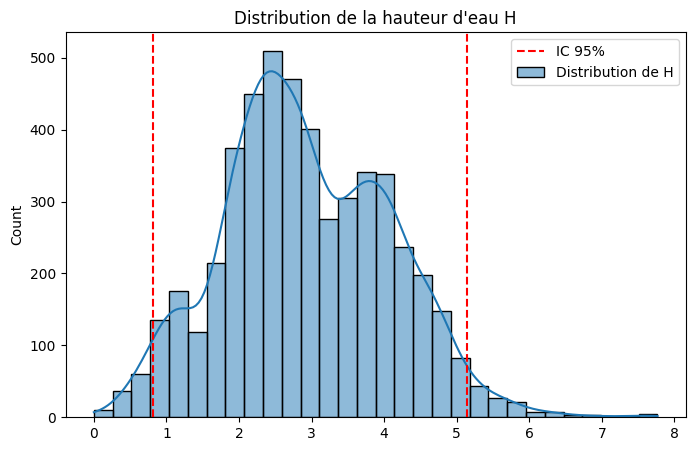

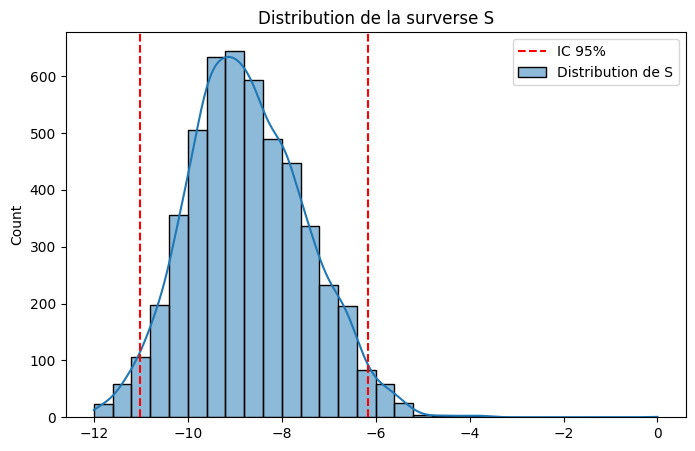

In [24]:

# Affichage des distributions
plt.figure(figsize=(8,5))
sns.histplot(H_samples, kde=True, bins=30, label="Distribution de H")
plt.axvline(H_lower, color="red", linestyle="dashed", label="IC 95%")
plt.axvline(H_upper, color="red", linestyle="dashed")
plt.legend()
plt.title("Distribution de la hauteur d'eau H")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(S_samples, kde=True, bins=30, label="Distribution de S")
plt.axvline(S_lower, color="red", linestyle="dashed", label="IC 95%")
plt.axvline(S_upper, color="red", linestyle="dashed")
plt.legend()
plt.title("Distribution de la surverse S")
plt.show()

In [27]:
H_stats = np.median(H_samples), np.mean(H_samples), np.percentile(H_samples, [2.5, 97.5])
S_stats = np.median(S_samples), np.mean(S_samples), np.percentile(S_samples, [2.5, 97.5])

print(f"\n🔹 H : Moy={H_stats[1]:.2f} m, Med={H_stats[0]:.2f} m, IC95%=[{H_stats[2][0]:.2f}, {H_stats[2][1]:.2f}] m")
print(f"🔹 S : Moy={S_stats[1]:.2f} m, Med={S_stats[0]:.2f} m, IC95%=[{S_stats[2][0]:.2f}, {S_stats[2][1]:.2f}] m")


🔹 H : Moy=2.93 m, Med=2.82 m, IC95%=[0.81, 5.15] m
🔹 S : Moy=-8.72 m, Med=-8.82 m, IC95%=[-11.01, -6.17] m
